In [1]:
import os, sys
os.chdir("..")
sys.path.append("..")

from utils.support import pkl_load
from train.run import MyDataset
from train.versions.augmentation import get_augmentation
from train.versions.model import get_model

from pathlib import Path
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
cfg = {
    "version": 4,
    
    "model_version": 4,
    "model_weights": "../output/models/hypothesis-4/fold-1/model.pt",
    
    "augmentation_version": 1,
    
    "device": "cuda",
    "batch_size": 800,
    "n_jobs": 4,
    
    "confidence": 0.7
}
pth = Path(f"inference_analysis/preview/v{cfg['version']}")
os.makedirs(pth, exist_ok=False)

In [3]:
dct = pkl_load(Path("../output/crossval_split/crossval_dct.pkl"))

df = dct[1]["valid"]
dataset = MyDataset(df, get_augmentation(cfg["augmentation_version"])["valid"])
dataloader = DataLoader(dataset, batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["n_jobs"])

In [4]:
model = get_model(cfg["model_version"], cfg["model_weights"])
model.to(cfg["device"])
pass

In [5]:
with torch.no_grad():
    model.eval()
    
    pred = np.array([])
    for x, y in dataloader:
        x, y = x.to(cfg["device"]), y.to(cfg["device"])
        p = model.forward(x)
        p = torch.sigmoid(p)
        p = p.to("cpu").numpy()
        pred = np.append(pred, p)
df["pred_proba"] = pred
df["pred"] = (df["pred_proba"] > 0.5).astype(int)

In [6]:
def preview(df, ncols, size, pth=None):
    nrows = int(len(df) / ncols) + (len(df) % ncols > 0)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            figsize=(ncols*size, nrows*size))
    fig.patch.set_facecolor('white')
    for ax in axs.flatten():
        ax.axis('off')
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        img = cv2.imread(str(row["cew_img"]), cv2.IMREAD_GRAYSCALE)
        ax.imshow(img, cmap=plt.get_cmap('gray'))
        ax.set_title(f"True-{row.label} | Pred-{round(row.pred_proba, 3)}")

    plt.tight_layout()
    if pth:
        plt.savefig(pth)
    plt.show()
    plt.close()

# False Negative

Total images: 10


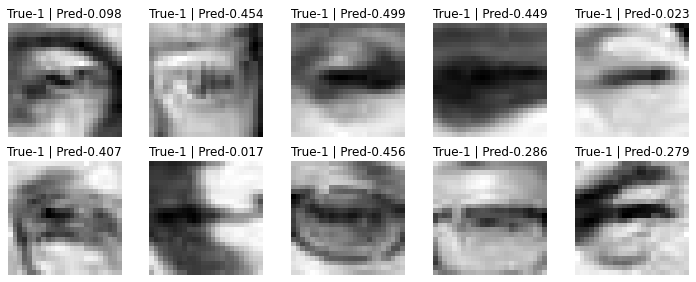

In [7]:
preview_df = df[(df["label"] != df["pred"]) & (df["label"] == 1)]
print(f"Total images: {preview_df.shape[0]}")
preview(preview_df, 5, 2, pth / "fn.png")

# False Positive

Total images: 11


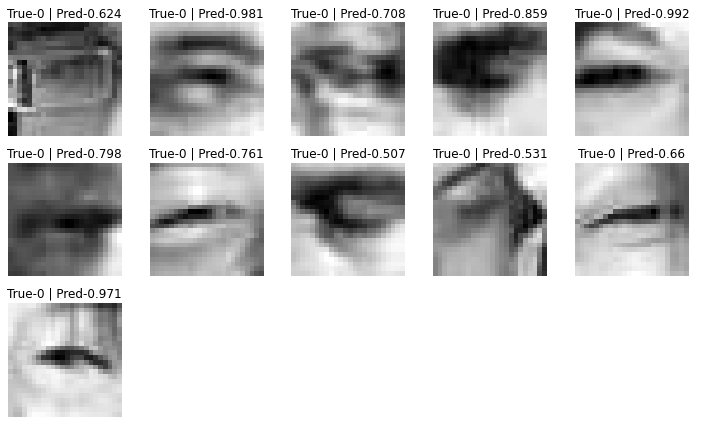

In [8]:
preview_df = df[(df["label"] != df["pred"]) & (df["label"] == 0)]
print(f"Total images: {preview_df.shape[0]}")
preview(preview_df, 5, 2, pth / "fp.png")

# True Positive with Low Confidence

Total images: 5


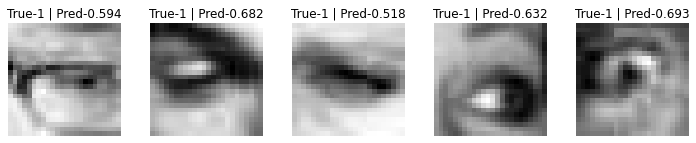

In [9]:
preview_df = df[
    (df["pred"] == 1) &
    
    (df["pred"] == df["label"]) &
    (df["pred_proba"] < cfg["confidence"])
]
print(f"Total images: {preview_df.shape[0]}")
preview(preview_df, 5, 2, pth / "tp_lowConf.png")

# True Negative with Low Confidence

Total images: 2


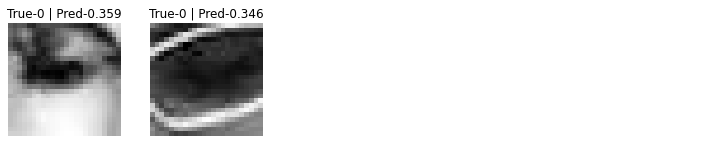

In [10]:
preview_df = df[
    (df["pred"] == 0) &
    
    (df["pred"] == df["label"]) &
    (df["pred_proba"] > (1 - cfg["confidence"]))
]
print(f"Total images: {preview_df.shape[0]}")
preview(preview_df, 5, 2, pth / "tn_lowConf.png")